### Import Packages

In [2]:
import pandas as pd
import logging 
import os
import time
import requests 
import tiktoken
import ray
import numpy as np
import json
import pickle
import openai

from math import ceil
from numba import jit
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# In order for ray to work, make sure you uninstall pydantic and reinstall this: pip install "pydantic<2"
from class_data.data import Data
from utils.system import *

# Set OPENAI KEY
os.environ["OPENAI_API_KEY"] = json.load(open(get_config() / 'api.json'))['openai_api_key']

import warnings
warnings.filterwarnings('ignore')

### Data

In [17]:
# Get SP500 candidates and set keys to the given year
def get_candidate():
    with open(get_data() / 'sp500_candidates.pkl', 'rb') as f:
        candidates = pickle.load(f)
    beginning_year = [date for date in candidates.keys() if date.month == 1]
    candidates = {date.year: candidates[date] for date in beginning_year if date in candidates}
    return candidates

# Get unique sp500 tickers
sp500_all = get_candidate()
sp500 = set()
for year, tickers in sp500_all.items():
    if year < 2000:
        continue
    sp500.update(tickers)
sp500 = list(sp500)

In [18]:
# Load openai embeddings
cc_emb = Data(folder_path=get_format_data() / 'openai', file_pattern='cc_emb_textemb3small_*')
cc_emb = cc_emb.concat_files()
cc_emb.shape

Loading Data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 748/748 [00:08<00:00, 83.89it/s]


(747323, 1)

In [19]:
# Load cc articles
cc_art = Data(folder_path=get_format_data() / 'art', file_pattern='cc_art_*')
cc_art = cc_art.concat_files()
cc_art.shape

Loading Data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 31.35it/s]


(747323, 11)

In [20]:
# Remove NAN values
index = cc_emb.reset_index()
index_null = index.loc[index.ada_embedding.isnull()].index.tolist()
cc_art = cc_art.reset_index()
cc_art = cc_art.loc[~cc_art.index.isin(index_null)]
cc_art = cc_art.set_index(['fid', 'date'])
cc_emb = cc_emb.dropna()
print(cc_emb.shape)
print(cc_art.shape)

(747321, 1)
(747321, 11)


In [21]:
# Firm-Level Risk
all_risk = pd.read_csv(get_data() / 'firmquarter_2022q1.csv', delimiter='\t', engine='python')
all_risk = all_risk.set_index(['gvkey', 'date'])
print(all_risk.columns.tolist())

['PRisk', 'NPRisk', 'Risk', 'PSentiment', 'NPSentiment', 'Sentiment', 'PRiskT_economic', 'PRiskT_environment', 'PRiskT_trade', 'PRiskT_institutions', 'PRiskT_health', 'PRiskT_security', 'PRiskT_tax', 'PRiskT_technology', 'company_name', 'hqcountrycode', 'isin', 'cusip', 'ticker', 'date_earningscall', 'Covid_Exposure', 'Covid_Neg_Sentiment', 'Covid_Pos_Sentiment', 'Covid_Net_Sentiment', 'Covid_Risk', 'SARS_Exposure', 'H1N1_Exposure', 'Zika_Exposure', 'Ebola_Exposure', 'Brexit_Exposure', 'Brexit_Neg_Sentiment', 'Brexit_Pos_Sentiment', 'Brexit_Net_Sentiment', 'Brexit_Risk']


In [64]:
# Link Data
link = pd.read_parquet(r'C:\Jonathan\QuantResearch\AlgoTradingModels\algofacto\trade_live\data_parquet\data_link.parquet.brotli')
link = link.loc[link.ticker.isin(sp500)]
link = link.drop_duplicates(subset='gvkey', keep='last')
link['gvkey'] = link['gvkey'].astype('int64')
sp500_gvkey = link['gvkey'].unique().tolist()
ticker_to_gvkey_mapping = link.set_index('ticker')['gvkey'].to_dict()
gvkey_to_ticker_mapping = link.set_index('gvkey')['ticker'].to_dict()

### Query

In [23]:
# Params
p_val = 0.15
query = "Risk, Uncertainty, Politics, Policy, Government, Regulation, Stability, Election, Legislation, Economy, Political risk, Policy uncertainty, Government regulation, Economic policy, Legislative changes, Risk management, Market stability, Political stability, Regulatory framework, Economic instability, Level of uncertainty, Impact of regulation, Government policy changes, Political risk assessment, Economic policy uncertainty, Long term stability, Risk assessment process, Political instability risk, Regulatory compliance issues, Political climate change"

In [24]:
# Get embedding of query
def get_emb(query):
    return np.array(openai.embeddings.create(input=[query.replace("\n", " ")], model='text-embedding-3-small').data[0].embedding).reshape(1, -1)

In [25]:
# Calculate score
query_emb = get_emb(query)
score = cosine_similarity(query_emb, np.stack(cc_emb['ada_embedding'].values))[0]
score = pd.DataFrame(score, index=cc_emb.index, columns=['score'])

In [26]:
# Relu Transformation
scores = np.array(score['score'])
percentile = 100 * (1 - p_val)
threshold = np.percentile(scores, percentile)
relu_score = np.maximum(0, score['score'] - threshold)
relu_score = relu_score.to_frame('score')

In [27]:
# Add metadata
relu_score['body_txt'] = cc_art['body_txt']
relu_score['ticker'] = cc_art['companyTicker']

In [28]:
# Change index to ('ticker', 'date')
relu_score = relu_score.reset_index().set_index(['ticker', 'date'])

In [29]:
# Get article associated to the maximum score per date
mask = (relu_score['score'] == relu_score.groupby(['ticker', 'date'])['score'].transform('max'))
max_article = relu_score[mask]
max_article = max_article[~max_article.index.duplicated(keep='first')]

In [30]:
# Calculate aggregrated score per date
mean_score = relu_score.groupby(['ticker', 'date'])['score'].mean()
mean_score = mean_score.sort_index().to_frame()

In [31]:
# Function to convert 'YYYY-MM-DD' to 'YYYYqQ'
def date_to_quarter(date):
    year = date.year  
    quarter = (date.month - 1) // 3 + 1 
    return f'{year}q{quarter}'

new_index = pd.MultiIndex.from_tuples([(x[0], date_to_quarter(x[1])) for x in mean_score.index])
mean_score.index = new_index
mean_score.index.names = ['ticker', 'date']

In [32]:
# Calculate aggregrated score per quarter
mean_score = mean_score.groupby(['ticker', 'date'])['score'].mean().to_frame('score')

### Compare with Firm-Level Risk

In [33]:
# Param
risk = 'PRisk'

In [34]:
# Set risk
compare_risk = all_risk[[risk]]

In [35]:
# Map ticker to gvkey
mean_score['gvkey'] = mean_score.index.get_level_values('ticker').map(ticker_to_gvkey_mapping)
print(f"Unique Tickers: {len(mean_score.index.get_level_values('ticker').unique())}")
mean_score = mean_score.dropna(subset='gvkey')
print(f"Unique Tickers without gvkey: {len(mean_score.index.get_level_values('ticker').unique())}")
mean_score['gvkey'] = mean_score['gvkey'].astype('int64')
mean_score = mean_score.reset_index().set_index(['gvkey', 'date'])

Unique Tickers: 655
Unique Tickers without gvkey: 642


In [36]:
# Number of CC per GVKEY
counts_per_gvkey = mean_score.groupby('gvkey').size()
print(f"Average Number of CC: {round(counts_per_gvkey.mean(), 2)}")
print(f"STD Number of CC: {round(counts_per_gvkey.std(), 2)}")
print(f"Max Number of CC: {round(counts_per_gvkey.max(), 2)}")
print(f"Min Number of CC: {round(counts_per_gvkey.min(), 2)}")

Average Number of CC: 59.71
STD Number of CC: 17.11
Max Number of CC: 72
Min Number of CC: 2


In [37]:
# Filter out tickers with less than 10 CC
mean_score = mean_score.groupby('gvkey').filter(lambda x: len(x) >= 10)
print(f"Unique Tickers with more than 10 CC: {len(mean_score.index.get_level_values('gvkey').unique())}")

Unique Tickers with more than 10 CC: 629


In [38]:
# Join
compare = mean_score.join(compare_risk)
compare = compare.reset_index().set_index(['gvkey', 'ticker', 'date'])

In [39]:
# Standardize
scaler = MinMaxScaler()
columns_to_scale = compare.columns
compare[columns_to_scale] = scaler.fit_transform(compare[columns_to_scale])

In [40]:
# Correlation no shift
corr = compare.groupby(['gvkey', 'ticker']).apply(lambda x: x[x.columns[0]].corr(x[x.columns[1]])).to_frame('corr')
print(f"Average Correlation: {round(corr.mean().values[0], 2)}")
print(f"STD Correlation: {round(corr.std().values[0], 2)}")
print(f"Max Correlation: {round(corr.max().values[0], 2)}")
print(f"Min Correlation: {round(corr.min().values[0], 2)}")

Average Correlation: 0.17
STD Correlation: 0.17
Max Correlation: 0.78
Min Correlation: -0.46


In [41]:
# Correlation shifted -1
compare_shift = compare.copy(deep=True)
compare_shift['score'] = compare.groupby(['gvkey'])['score'].shift(-1).dropna()
corr = compare_shift.groupby(['gvkey', 'ticker']).apply(lambda x: x[x.columns[0]].corr(x[x.columns[1]])).to_frame('corr')
print(f"Average Correlation: {round(corr.mean().values[0], 2)}")
print(f"STD Correlation: {round(corr.std().values[0], 2)}")
print(f"Max Correlation: {round(corr.max().values[0], 2)}")
print(f"Min Correlation: {round(corr.min().values[0], 2)}")

Average Correlation: 0.05
STD Correlation: 0.16
Max Correlation: 0.71
Min Correlation: -0.49


In [42]:
# Correlation shifted 1
compare_shift = compare.copy(deep=True)
compare_shift['score'] = compare.groupby(['gvkey'])['score'].shift(1).dropna()
corr = compare_shift.groupby(['gvkey', 'ticker']).apply(lambda x: x[x.columns[0]].corr(x[x.columns[1]])).to_frame('corr')
print(f"Average Correlation: {round(corr.mean().values[0], 2)}")
print(f"STD Correlation: {round(corr.std().values[0], 2)}")
print(f"Max Correlation: {round(corr.max().values[0], 2)}")
print(f"Min Correlation: {round(corr.min().values[0], 2)}")

Average Correlation: 0.07
STD Correlation: 0.17
Max Correlation: 0.71
Min Correlation: -0.35


<Axes: xlabel='gvkey,ticker,date'>

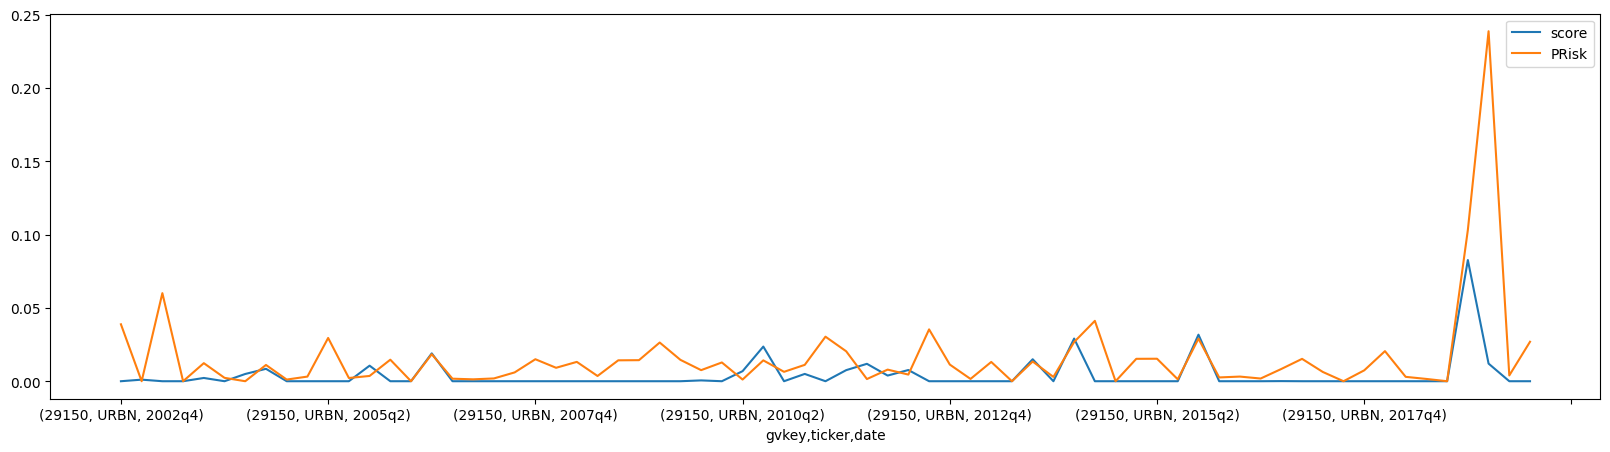

In [43]:
# Plot Max
max_corr_gvkey = corr.loc[corr['corr'] == corr['corr'].max()].index[0][0]
max_corr_index = compare.loc[compare.index.get_level_values('gvkey') == max_corr_gvkey]
max_corr_index.plot(figsize=(20, 5))

<Axes: xlabel='gvkey,ticker,date'>

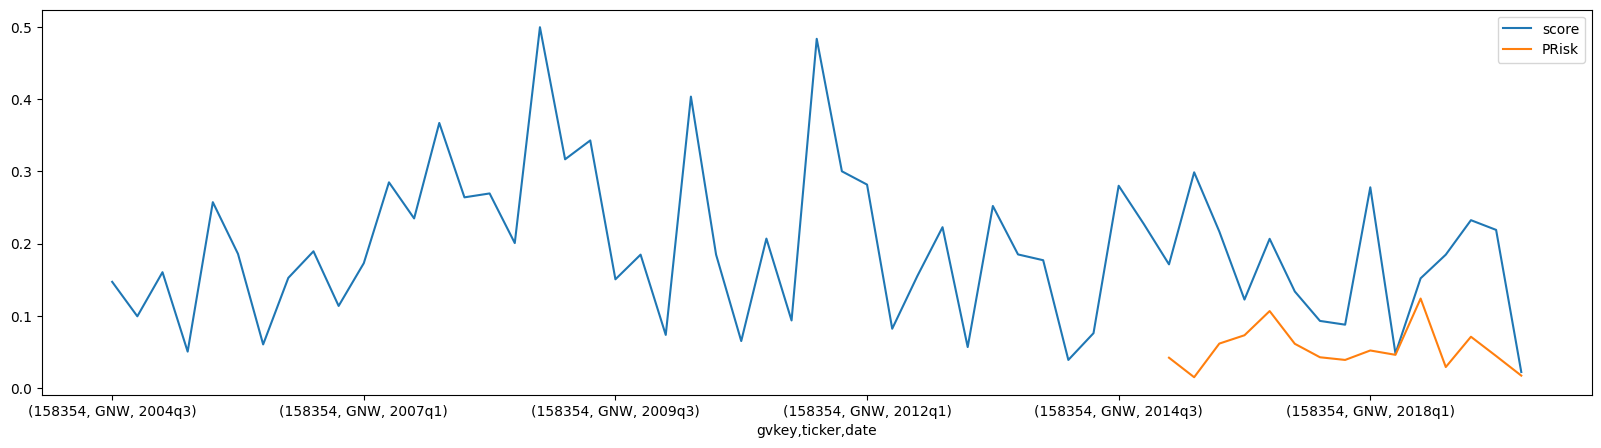

In [44]:
# Plot Min
min_corr_gvkey = corr.loc[corr['corr'] == corr['corr'].min()].index[0][0]
min_corr_index = compare.loc[compare.index.get_level_values('gvkey') == min_corr_gvkey]
min_corr_index.plot(figsize=(20, 5))

<Axes: xlabel='gvkey,ticker,date'>

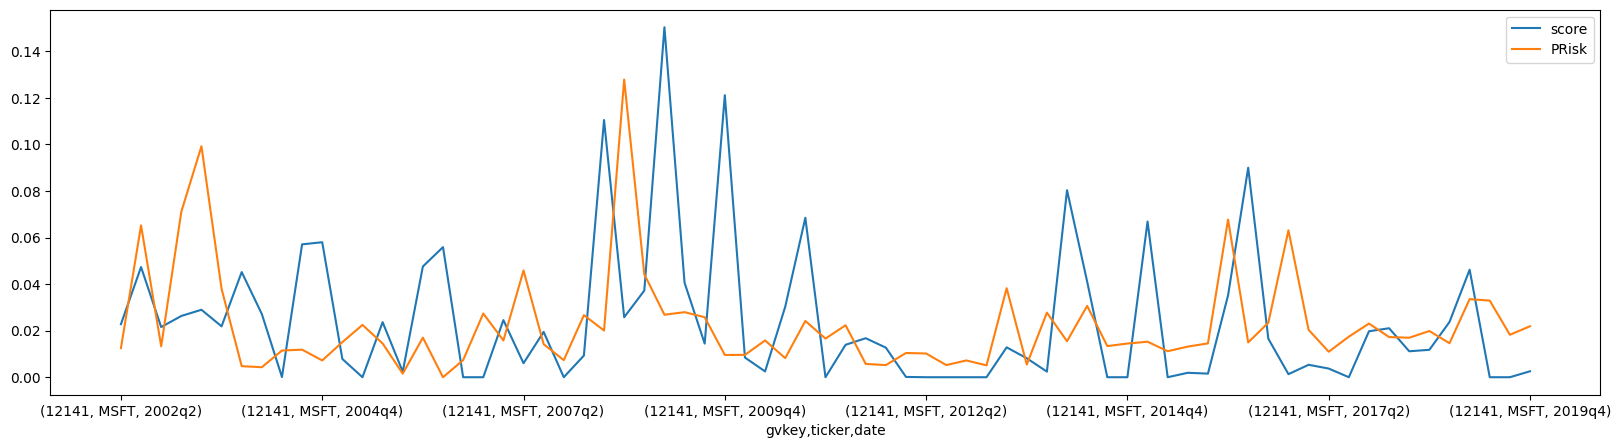

In [45]:
# Plot Stock
stock = 'MSFT'
stock_corr_index = compare.loc[compare.index.get_level_values('ticker') == stock]
stock_corr_index.plot(figsize=(20, 5))

### Compare with JKP Return and Characteristics

In [287]:
# Read in JKP daily ret
daily_ret = pd.read_csv(get_data() / 'jkp_daily_ret.csv')

In [289]:
# Export JKP daily ret into chunks
chunks = np.array_split(daily_ret, 50)
for i, df in enumerate(chunks, 1):
    print(i)
    df.to_parquet(get_format_data() / 'jkp' / f'daily_ret_{i}.parquet.brotli', compression='brotli')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [3]:
# Load JKP daily ret
daily_ret = Data(folder_path=get_format_data() / 'jkp', file_pattern='daily_ret_*')
daily_ret = daily_ret.concat_files()
daily_ret.shape

Loading Data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.18it/s]


(219492890, 6)

In [49]:
# Load JKP daily ret
characteristics = Data(folder_path=get_format_data() / 'jkp', file_pattern='characteristics_*')
characteristics = characteristics.concat_files()
characteristics = characteristics.dropna(subset='gvkey')
characteristics['gvkey'] = characteristics['gvkey'].astype('int64')
characteristics.shape

Loading Data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.77it/s]


(3394206, 444)

In [51]:
# Create id and gvkey map to join JKP datasets
id_gvkey = characteristics[['id', 'gvkey']]
id_gvkey = id_gvkey.drop_duplicates(subset='gvkey', keep='last')
id_to_gvkey_mapping = id_gvkey.set_index('id')['gvkey'].to_dict()

In [15]:
# Add gvkey to JKP dataset
daily_ret['gvkey'] = daily_ret['id'].map(id_to_gvkey_mapping)
daily_ret = daily_ret.dropna(subset='gvkey')
daily_ret['gvkey'] = daily_ret['gvkey'].astype('int64')

In [52]:
# Retrieve GVKEY data used in index
daily_ret = daily_ret.loc[daily_ret.gvkey.isin(compare.index.get_level_values('gvkey').unique().tolist())]
characteristics = characteristics.loc[characteristics.gvkey.isin(compare.index.get_level_values('gvkey').unique().tolist())]

In [59]:
# Convert date to datetime
daily_ret['date'] = pd.to_datetime(daily_ret['date'].astype(str), format='%Y%m%d')
characteristics['date'] = pd.to_datetime(characteristics['date'].astype(str), format='%Y%m%d')

In [65]:
# Add ticker to daily_ret and characteristics
daily_ret['ticker'] = daily_ret['gvkey'].map(gvkey_to_ticker_mapping)
characteristics['ticker'] = characteristics['gvkey'].map(gvkey_to_ticker_mapping)

In [68]:
# Set index of JKP data to same as index
daily_ret = daily_ret.set_index(['gvkey', 'ticker', 'date'])
daily_ret = daily_ret.sort_index(level=['ticker', 'date'])
characteristics = characteristics.set_index(['gvkey', 'ticker', 'date'])
characteristics = characteristics.sort_index(level=['ticker', 'date'])

In [72]:
# Convert index to quarter
new_index = pd.MultiIndex.from_tuples([(x[0], x[1], date_to_quarter(x[2])) for x in daily_ret.index])
daily_ret.index = new_index
daily_ret.index.names = ['gvkey', 'ticker', 'date']
new_index = pd.MultiIndex.from_tuples([(x[0], x[1], date_to_quarter(x[2])) for x in characteristics.index])
characteristics.index = new_index
characteristics.index.names = ['gvkey', 'ticker', 'date']